In [151]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5py
import pandas as pd
#sess = tf.InteractiveSession()

In [2]:
def load_dataset():
    train_dataset = h5py.File('signs_dataset/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('signs_dataset/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

No. of Training samples (batch): 1080
No. of Test samples: 120
No. of gestures: 6
Image format (Len, Wid, Chan): 64 * 64 * 3


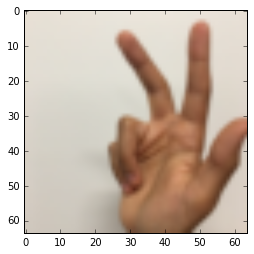

In [182]:
#loading the dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
index = 152
plt.imshow(train_set_x_orig[index])
#print(train_set_x_orig.shape)
print("No. of Training samples (batch): %d"%train_set_x_orig.shape[0])
print("No. of Test samples: %d"%test_set_x_orig.shape[0])
print("No. of gestures: %d"%classes.size)
print("Image format (Len, Wid, Chan): %d * %d * %d"%(train_set_x_orig.shape[1],train_set_x_orig.shape[2],train_set_x_orig.shape[3]))


In [168]:
arr = np.eye(6)[train_set_y]

arr = np.reshape(arr,[1080,6])
print(arr.shape)

(1080, 6)


In [5]:
#x1_tensor = tf.reshape(train_set_x_orig[:,:,:,0], [-1, 64, 64, 1])
#x2_tensor = tf.reshape(train_set_x_orig[:,:,:,1], [-1, 64, 64, 1])
#x3_tensor = tf.reshape(train_set_x_orig[:,:,:,2], [-1, 64, 64, 1])
batch_size = train_set_x_orig.shape[0]
x_tensor = tf.reshape(train_set_x_orig, [-1, 64, 64, 3],name="x_tensor") # -1 because batch size varies for train and test data
x_tensor = tf.cast(x_tensor,tf.float32) # casting as the original was uint8

In [19]:
def tf_var_normInit(shape):
    '''Helper function to create a weight variable initialized with
    a normal distribution

    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01,dtype=tf.float32)
    return tf.Variable(initial)

In [23]:
def conv_params(lx_filter_size,ch_N,lx_filter_Num):
    '''Helper function to create weights and biases

    Parameters
    ----------
    lx_filter_size : filter of (size x size) of layer 'x'
    
    ch_N : channel size of the filter i.e. (size x size x ch_N)
    
    lx_filter_Num : No of filters required for filter of layer 'x'
    '''
    
    W_conv = tf_var_normInit([lx_filter_size, lx_filter_size, ch_N, lx_filter_Num])
    B_conv = tf_var_normInit([lx_filter_Num])
    return W_conv, B_conv

In [111]:
#conv1 layer to convert the input to Lenet format
ch_X = train_set_x_orig.shape[3]
l1_filter_size = 3 # filter size of n*n for convolution
l1_filter_Num = 3 # No. of filters required

W_conv1, B_conv1 = conv_params(l1_filter_size,ch_X,l1_filter_Num)

# %% Now we can build a graph which does the first layer of convolution:
# we define our stride as batch x height x width x channels
# instead of pooling, we use strides of 2 and more layers
# with smaller filters.
h_conv1 = tf.nn.relu(
    tf.nn.conv2d(
        input=x_tensor,
        filter=W_conv1,
        strides=[1, 2, 2, 1],
        padding='SAME') 
    + B_conv1,
    name="h_conv1")

(1080, 32, 32, 3)


In [112]:
#conv2 for adhering to Lenet
ch_1 = tf.cast(h_conv1.shape[3],tf.int32)
l2_filter_size = 5 # filter size of n*n for convolution
l2_filter_Num = 6 # No. of filters required

W_conv2, B_conv2 = conv_params(l2_filter_size,ch_1,l2_filter_Num)

h_conv2 = tf.nn.relu(
    tf.nn.conv2d(
        input=h_conv1,
        filter=W_conv2,
        strides=[1, 1, 1, 1],
        padding='VALID') 
    + B_conv2,
    name="h_conv2")

(1080, 28, 28, 6)


In [118]:
#avg pooling layer
ch_2 = tf.cast(h_conv2.shape[3],tf.int32)
k_size = [1,2,2,1] #filter size
#h_conv2 = tf.reshape(h_conv2,[1080,28,28,6])
h_pool2 = tf.nn.avg_pool(h_conv2,k_size,strides=[1, 2, 2, 1],padding='VALID',name="h_pool2")
print(h_pool2.get_shape())

(1080, 14, 14, 6)


In [119]:
#conv3 for adhering to Lenet
ch_3 = tf.cast(h_pool2.shape[3],tf.int32)
l3_filter_size = 5 # filter size of n*n for convolution
l3_filter_Num = 16 # No. of filters required

W_conv3, B_conv3 = conv_params(l3_filter_size,ch_3,l3_filter_Num)

h_conv3 = tf.nn.relu(
    tf.nn.conv2d(
        input=h_pool2,
        filter=W_conv3,
        strides=[1, 1, 1, 1],
        padding='VALID') 
    + B_conv3,
    name="h_conv3")

print(h_conv3.shape)

(1080, 10, 10, 16)


In [122]:
#conv4 for adhering to Lenet
ch_4 = tf.cast(h_conv3.shape[3],tf.int32)
l4_filter_size = 2 # filter size of n*n for convolution
l4_filter_Num = 16 # No. of filters required

W_conv4, B_conv4 = conv_params(l4_filter_size,ch_4,l4_filter_Num)

h_conv4 = tf.nn.relu(
    tf.nn.conv2d(
        input=h_conv3,
        filter=W_conv4,
        strides=[1, 2, 2, 1],
        padding='VALID') 
    + B_conv4,
    name="h_conv4")

print(h_conv4.shape)

(1080, 5, 5, 16)


In [125]:
# %% We'll now reshape so we can connect to a fully-connected layer:
h_conv4_flat = tf.reshape(h_conv4, [-1, 5 * 5 * 16])
print(h_conv4_flat.get_shape())

(1080, 400)


In [128]:
# %% Create a fully-connected layer 1:
n_fc1 = 120
W_fc1 = tf_var_normInit([5 * 5 * 16, n_fc1])
b_fc1 = tf_var_normInit([n_fc1])
h_fc1 = tf.nn.relu(tf.matmul(h_conv4_flat, W_fc1) + b_fc1)

In [129]:
# %% Create a fully-connected layer 2:
n_fc2 = 84
W_fc2 = tf_var_normInit([n_fc1, n_fc2])
b_fc2 = tf_var_normInit([n_fc2])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

In [138]:
# %% And finally our softmax layer:
W_fc3 = tf_var_normInit([n_fc2, 6])
b_fc3 = tf_var_normInit([6])
y_pred = tf.nn.softmax(tf.matmul(h_fc2, W_fc3) + b_fc3)
print(y_pred.get_shape())

(1080, 6)


In [169]:
y = arr
print(y.shape)
# %% Define loss/eval/training functions
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

(1080, 6)


In [171]:
# %% Monitor accuracy
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
print(accuracy)

Tensor("Mean_1:0", shape=(), dtype=float32)


In [178]:
# %% We now create a new session to actually perform the initialization the
# variables:
sess = tf.Session()
sess.run(optimizer)

FailedPreconditionError: Attempting to use uninitialized value beta2_power
	 [[Node: beta2_power/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_53"], _device="/job:localhost/replica:0/task:0/cpu:0"](beta2_power)]]

Caused by op 'beta2_power/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-169-90b23bb118c6>", line 5, in <module>
    optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/adam.py", line 129, in _create_slots
    trainable=False)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 1679, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 330, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1400, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta2_power
	 [[Node: beta2_power/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_53"], _device="/job:localhost/replica:0/task:0/cpu:0"](beta2_power)]]


In [173]:
# %% We'll train in minibatches and report accuracy:
batch_size = 100
n_epochs = 5